**Проект 3. EDA + Feature Engineering. Соревнование на Kaggle**

In [1]:
# Импортируем библиотеки
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
# Импортируем библиотеки
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# анализ текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time

# Библиотека кодирования
import category_encoders as ce

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
# Подгрузим наши данные

df_train = pd.read_csv('hotels_train.csv.zip') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv.zip') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv.zip') # самбмишн

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [9]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [10]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [12]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [14]:
# заполняем отсутствующие значения
df['lat'] = df['lat'].fillna(0)
df['lng'] = df['lng'].fillna(0)

In [15]:
# Формируем признак страна из признака адрес отеля 
df['hotel_country'] = df['hotel_address'].apply(lambda s: s.split()[-1])
df['hotel_country'] = df['hotel_country'].apply(lambda s: 'United Kingdom' if s == 'Kingdom' else s)
df['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [16]:
# Формируем признак города из признака адрес отеля
df['hotel_city'] = df['hotel_address'].apply(lambda s: s.split()[-2])
df['hotel_city'] = df['hotel_city'].apply(lambda s: 'London' if s == 'United' else s)
df['hotel_city'].value_counts()

London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: hotel_city, dtype: int64

In [17]:
# Кодируем признак hotel_city методом OneHotEncoder  
encoder = ce.OneHotEncoder(cols=['hotel_city'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['hotel_city'])
df = pd.concat([df, type_bin], axis=1)

# Удаляем признак hotel_city
df = df.drop(['hotel_city'], axis = 1)

/home/director/anaconda3/envs/DS/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [18]:
# Преобразуем признак review_date
df['review_date'] = pd.to_datetime(df['review_date'])
df['month'] = df['review_date'].dt.month

In [19]:
def season(m):
    if (1 <= m <= 2) or m == 12:
        return "winter"
    if 3 <= m <= 5:
        return "spring"
    if 6 <= m <= 8:
        return "summer"
    if 9 <= m <= 11:
        return "autumn"

df['month'] = df['month'].apply(lambda m:season(m))

In [20]:
# Кодируем признак month методом OneHotEncoder  
encoder = ce.OneHotEncoder(cols=['month'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df['month'])
df = pd.concat([df, type_bin], axis=1)

# Удаляем признак month и review_date
df = df.drop(['month', 'review_date'], axis = 1)

/home/director/anaconda3/envs/DS/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [21]:
# обрабатываем признак tags
di = dict()
def fun(s):
    ss = s.replace('[\'', '').replace('\']', '').replace('\'', '').split(',')
    for i in ss:
        i = i.strip()
        if i not in di:
            di[i] = 0
        else:
            di[i] +=1
    li = list(ss)
    for j in range(len(li)): 
        li[j] = li[j].strip()
    return str(li)

df['tags'] = df['tags'].apply(fun)

# сортируем словарь
di = dict(sorted(di.items(), key=lambda x: x[1], reverse=True))

# добавляем топ 20 отелей
top20 = list(di.keys())[:20]

def dftop(xf, d):
    for i in d:
        #if xf[i] is not xf:
        xf[i] = 0
    return xf

df = dftop(df, top20)

# кодируем признаки
for i in top20:
    df[i] = df['tags'].apply(lambda x: 1 if i in x else 0)
    
    
df = df.drop(['tags'], axis=1)
df.head(2)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,Stayed 4 nights,Double Room,Standard Double Room,Superior Double Room,Family with older children,Deluxe Double Room,Double or Twin Room,Stayed 5 nights,Standard Double or Twin Room,Classic Double Room
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,1,0,0,0,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# преобразование признака days_since_review
df['review_update'] = df['days_since_review'].apply(lambda s: s.split()[0])
df['review_update'] = df['review_update'].astype('int')

# удаляем признак days_since_review
df = df.drop(['days_since_review'], axis=1)

In [23]:
# Анализ отзывов negative_review и positive_review
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

# анализ позитивных отзывов
df['pos_review'] = df['positive_review'].apply(lambda s: sent_analyzer.polarity_scores(s)['pos'])

# анализ негативных отзывов
df['neg_review'] = df['negative_review'].apply(lambda s: sent_analyzer.polarity_scores(s)['neg'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/director/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<AxesSubplot:>

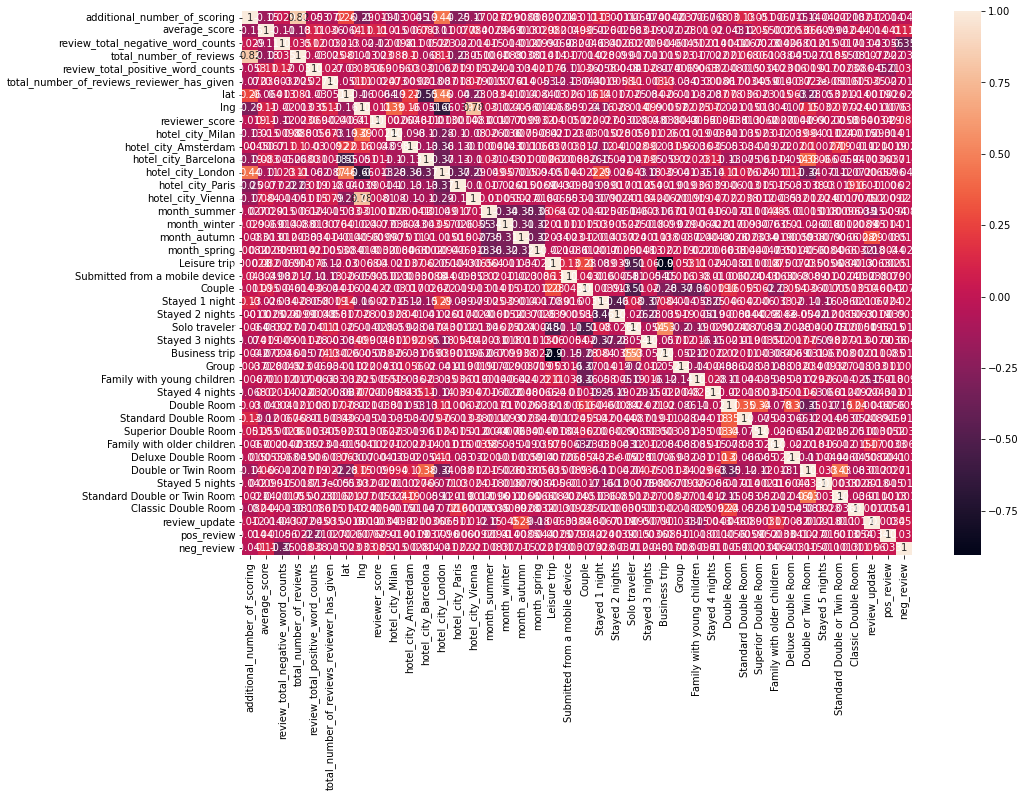

In [24]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df.drop(['sample'], axis=1).corr(), annot=True)

In [25]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 43 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   review_total_positive_word_counts           515738 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 6   lat                                         515738 non-null  float64
 7   lng                                         515738 non-null  float64
 8   sample                                      515738 non-null  int64  
 9   reviewer_score                              515738 non-null  float64
 

In [27]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [28]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [29]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 42), (386803, 42), (386803, 41), (309442, 41), (77361, 41))

In [30]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [31]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   12.3s finished


In [32]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.8999481194227923


<AxesSubplot:>

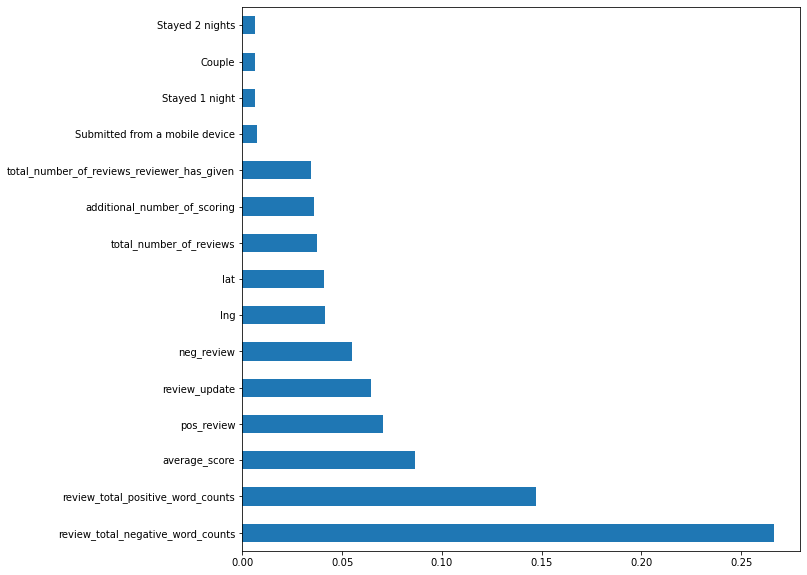

In [33]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [34]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,reviewer_score,hotel_city_Milan,...,Superior Double Room,Family with older children,Deluxe Double Room,Double or Twin Room,Stayed 5 nights,Standard Double or Twin Room,Classic Double Room,review_update,pos_review,neg_review
102094,141,8.3,0,1806,26,9,45.486874,9.201841,0.0,1,...,0,0,0,0,0,0,0,120,0.402,1.000
1646,1471,9.1,2,4802,5,2,51.527847,-0.088947,0.0,0,...,0,0,0,0,0,0,0,513,0.000,0.000
47894,1100,9.1,0,3611,7,1,51.508404,-0.106799,0.0,0,...,0,0,0,0,0,0,0,322,0.000,1.000
29186,229,8.9,37,2369,8,45,41.390517,2.172564,0.0,0,...,0,0,0,0,0,0,0,17,0.661,0.237
67158,589,7.0,0,4231,27,2,52.366373,4.893050,0.0,0,...,0,0,0,1,0,1,0,161,0.316,1.000
54035,487,8.8,0,1805,17,1,51.474469,-0.019428,0.0,0,...,0,0,0,0,0,0,0,382,0.587,1.000
115938,620,9.0,69,1974,11,2,51.506558,-0.004514,0.0,0,...,0,0,0,0,0,0,0,61,0.729,0.092
87068,1471,9.1,6,4802,20,1,51.527847,-0.088947,0.0,0,...,0,0,0,0,0,0,0,555,0.378,0.427
31568,726,8.6,22,4530,0,11,52.341943,4.875960,0.0,0,...,0,0,0,0,0,0,0,1,0.621,0.000
68873,589,7.0,3,4231,2,1,52.366373,4.893050,0.0,0,...,0,0,0,1,0,1,0,177,1.000,0.688


In [35]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [36]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [37]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    9.6s finished


In [38]:
predict_submission

array([8.756, 7.205, 8.626, ..., 8.024, 9.597, 7.347])

In [39]:
list(sample_submission)

['reviewer_score', 'id']

In [40]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.756,488440
1,7.205,274649
2,8.626,374688
3,9.764,404352
4,9.558,451596
5,8.462,302161
6,7.880,317079
7,7.482,13963
8,8.334,159785
9,7.761,195089
